# Forward modeling tutorial using mosaic images
## Generate simulated spectra

In this tutorial I'll show you how to create 1D and 2D forward modeled grism spectra

In [1]:
from grizli import model
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import os

## Seaborn is used to make plots look nicer. 
## If you don't have it, you can comment it out and it won't affect the rest of the code
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Read in spectra

In [45]:
## Quiescent galaxy spectra extracted using Grizli.
## I prefer to use .npy files for data arrays, these must be read in using np.load().

wv_102, fl_102, er_102 = np.load('galaxy_spec_g102.npy')
wv_141 ,fl_141 ,er_141 = np.load('galaxy_spec_g141.npy')

## Read in BeamCutout

By saving out all the BeamCutouts from the previous tutorial [Extract_beam](https://github.com/ivastar/clear/blob/master/notebooks/forward_modeling/Extract_beam.ipynb)
we can skip straight to the cutout object.

In [3]:
co = model.BeamCutout(fits_file='beams/o22.0_21156.g102.A.fits')

## Generate flat

Here I create a flat model to remove the transmission curve from the final 1D product.

In [4]:
flat = co.flat_flam.reshape(co.beam.sh_beam)

## ffl will be our transmission curve
fwv, ffl, e = co.beam.optimal_extract(flat, bin=0)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:545: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


## Read in model

In [5]:
## I've included several models in the model directory
mwv, mfl = np.load('model_spec/m0.019_a2.5_dt8.0_spec.npy')

## Redshift and Forward model

compute_model will generate the 2D model using your model spectra. Here I've redshifted the spectra out to z=1.249 to match the galaxy.

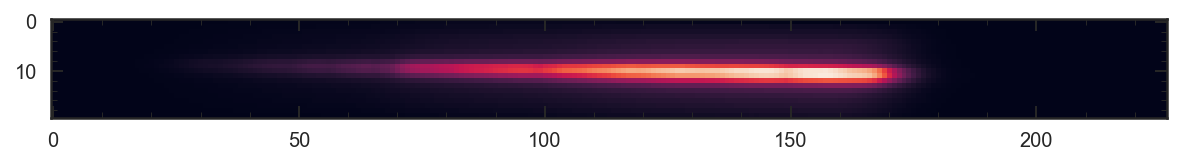

In [6]:
co.beam.compute_model(spectrum_1d=[mwv * (1 + 1.249), mfl])

## plot the spectra
plt.figure(figsize=[10,5])
plt.imshow(co.beam.model)

## Extract the model (error array here is meaningless)

In [7]:
w, f, e = co.beam.optimal_extract(co.beam.model, bin=0)

In [8]:
## interpolate spectra to match galaxy spectra
ifl = interp1d(w,f/ffl)(wv)

The models created here are at an arbitrary flux. In order to scale the models we can minimize 

$$\chi^2 =\sum_i \left(\frac{D_i-C*M_i}{\sigma_i}\right)^2$$

In [13]:
## function to scale model
def Scale_model(D, sig, M):
    return np.sum(((D * M) / sig ** 2)) / np.sum((M ** 2 / sig ** 2))

In [10]:
##Scale model
C = Scale_model(fl, er,ifl)

(0, 4e-18)

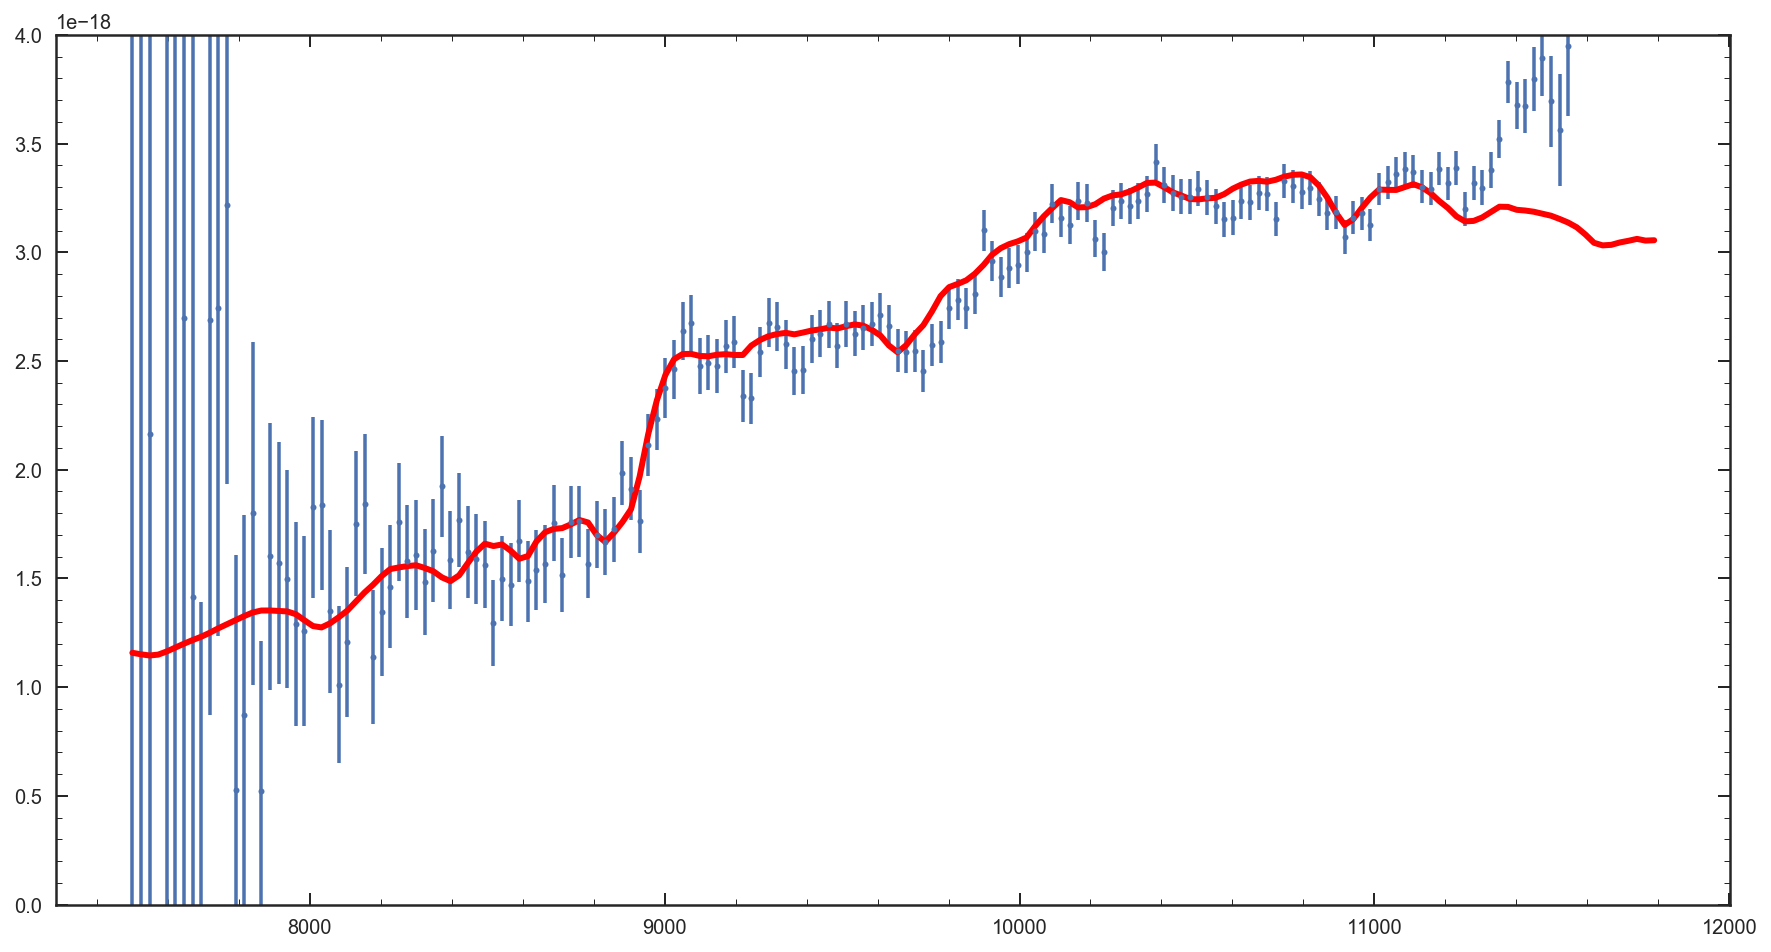

In [11]:
plt.figure(figsize=[15,8])

plt.errorbar(wv, fl, er, linestyle='None', marker='o', markersize=3)
plt.plot(wv, C*ifl, 'r', linewidth=3)
plt.ylim(0,0.4E-17)

In [2]:
class Gen_spec(object):
    def __init__(self, beam_102, beam_141, redshift, spec_file_102, spec_file_141, 
                minwv_102 = 7800, maxwv_102 = 11500,
                minwv_141 = 11300, maxwv_141 = 16000):
        self.beam_102 = model.BeamCutout(fits_file = beam_102)
        self.beam_141 = model.BeamCutout(fits_file = beam_141)
        self.redshift = redshift       
        """ 


        """

        self.gal_wv_102, self.gal_fl_102, self.gal_er_102 = np.load(spec_file_102)

        IDX = [U for U in range(len(self.gal_wv_102)) if minwv_102 <= self.gal_wv_102[U] <= maxwv_102]

        self.gal_wv_rf_102 = self.gal_wv_102[IDX] / (1 + self.redshift)
        self.gal_wv_102 = self.gal_wv_102[IDX]
        self.gal_fl_102 = self.gal_fl_102[IDX]
        self.gal_er_102 = self.gal_er_102[IDX]

        self.gal_wv_141, self.gal_fl_141, self.gal_er_141 = np.load(spec_file_141)

        IDX = [U for U in range(len(self.gal_wv_141)) if minwv_141 <= self.gal_wv_141[U] <= maxwv_141]

        self.gal_wv_rf_141 = self.gal_wv_141[IDX] / (1 + self.redshift)
        self.gal_wv_141 = self.gal_wv_141[IDX]
        self.gal_fl_141 = self.gal_fl_141[IDX]
        self.gal_er_141 = self.gal_er_141[IDX]

        ## Get sensitivity function
        flat = self.beam_102.flat_flam.reshape(self.beam_102.beam.sh_beam)
        fwv, ffl, e = self.beam_102.beam.optimal_extract(flat, bin=0)
        
        self.filt_102 = interp1d(fwv, ffl)(self.gal_wv_102)
        
        flat = self.beam_141.flat_flam.reshape(self.beam_141.beam.sh_beam)
        fwv, ffl, e = self.beam_141.beam.optimal_extract(flat, bin=0)
        
        self.filt_141 = interp1d(fwv, ffl)(self.gal_wv_141)
        
    def Sim_spec(self, model_file, model_redshift = 0, dust = 0):
        model_wv, model_fl = np.load(model_file)
        
        if model_redshift ==0:
            model_redshift = self.redshift 
        
        ## Compute the models
        self.beam_102.compute_model(spectrum_1d=[model_wv*(1+model_redshift),model_fl])
        self.beam_141.compute_model(spectrum_1d=[model_wv*(1+model_redshift),model_fl])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam_102.beam.optimal_extract(self.beam_102.model , bin=0)

        ifl = interp1d(w, f)(self.gal_wv_102)
        
        C = Scale_model(self.gal_fl_102, self.gal_er_102, ifl / self.filt_102)

        self.fl_102 = C * ifl / self.filt_102
        
        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam_141.beam.optimal_extract(self.beam_141.model , bin=0)

        ifl = interp1d(w, f)(self.gal_wv_141)
        
        C = Scale_model(self.gal_fl_141, self.gal_er_141, ifl / self.filt_141)

        self.fl_141 = C * ifl / self.filt_141

In [4]:
beam_102 = glob('beams/o*g102*')
beam_141 = glob('beams/o*g141*')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


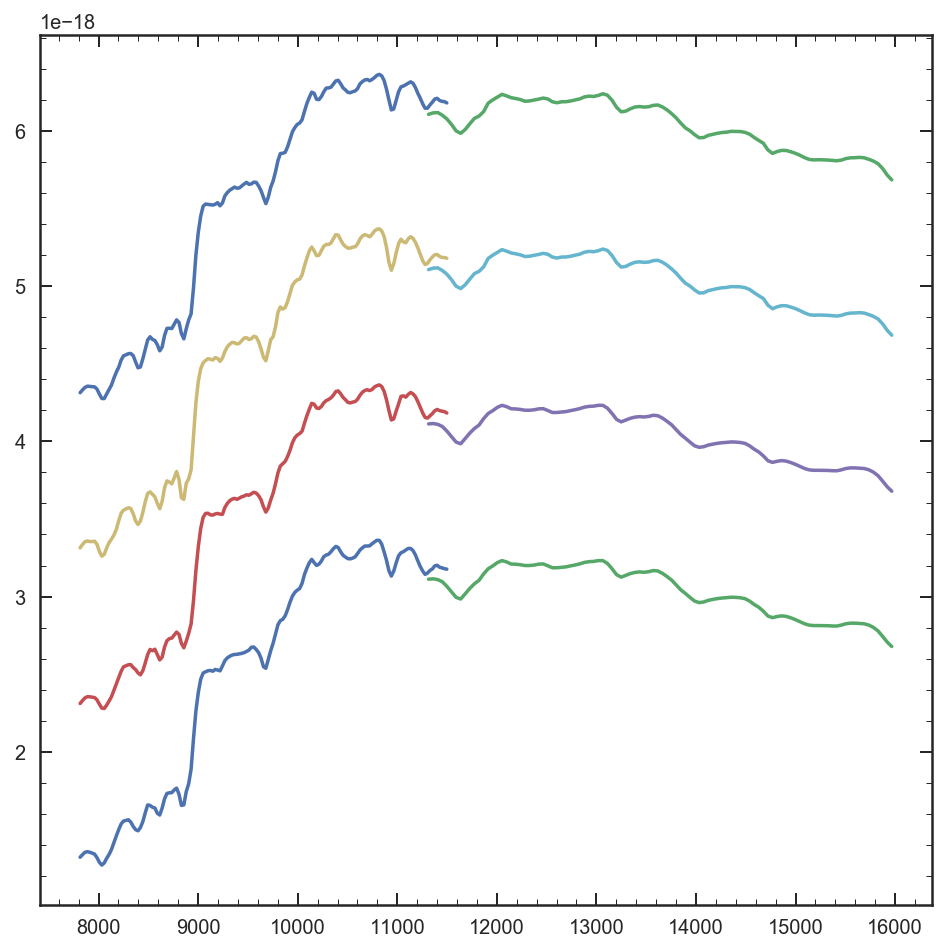

In [15]:
plt.figure(figsize=[8,8])

for i in range(len(beam_102)):
    sp = Gen_spec(beam_102[i],beam_141[i//2], 1.255, 'galaxy_spec_g102.npy', 'galaxy_spec_g141.npy')
    sp.Sim_spec('model_spec/m0.019_a2.5_dt8.0_spec.npy')
    
    plt.plot(sp.gal_wv_102, sp.fl_102+(i*0.1E-17))
    plt.plot(sp.gal_wv_141, sp.fl_141+(i*0.1E-17))    

## Forward modeling with MultiBeam

In [21]:
from grizli import multifit

In [38]:
## Read in model
mwv, mfl = np.load('model_spec/m0.019_a2.5_dt8.0_spec.npy')

## Read in beam information
mb = multifit.MultiBeam('beams/gnd_21156.beams.fits')

## Create model
spec = mb.get_flat_model(spectrum_1d = [mwv*2.25,mfl])

## Extract model and flat
sp = mb.optimal_extract(spec)
flat = mb.optimal_extract(mb.flat_flam[mb.fit_mask])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3449: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3454: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3455: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 flt_files/ib3721xiq_flt.fits G141
2 flt_files/ib3721xmq_flt.fits G141
3 flt_files/ib3721xyq_flt.fits G141
4 flt_files/ib3721y2q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3420: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 flt_files/ib3725dyq_flt.fits G141
6 flt_files/ib3725e2q_flt.fits G141
7 flt_files/ib3725eeq_flt.fits G141
8 flt_files/ib3725eiq_flt.fits G141
9 flt_files/icat21cfq_flt.fits G102
10 flt_files/icat21coq_flt.fits G102
11 flt_files/icat21dgq_flt.fits G102
12 flt_files/icat21dlq_flt.fits G102
13 flt_files/icat25hcq_flt.fits G102
14 flt_files/icat25hiq_flt.fits G102
15 flt_files/icat25icq_flt.fits G102
16 flt_files/icat25iiq_flt.fits G102
17 flt_files/icxt51jvq_flt.fits G102
18 flt_files/icxt51jwq_flt.fits G102
19 flt_files/icxt51jzq_flt.fits G102
20 flt_files/icxt51k1q_flt.fits G102
21 flt_files/icxt52i0q_flt.fits G102
22 flt_files/icxt52i1q_flt.fits G102
23 flt_files/icxt52i4q_flt.fits G102
24 flt_files/icxt52i6q_flt.fits G102
25 flt_files/icxt53i9q_flt.fits G102
26 flt_files/icxt53iaq_flt.fits G102
27 flt_files/icxt53idq_flt.fits G102
28 flt_files/icxt53ifq_flt.fits G102
29 flt_files/icxt55krq_flt.fits G102
30 flt_files/icxt55ksq_flt.fits G102
31 flt_files/icxt55kvq_flt.fits G102
32 flt

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1354: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1359: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:545: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/min

In [44]:
## set model
mfl_102 = sp['G102']['flux']/flat['G102']['flux']
mwv_102 = sp['G102']['wave'][mfl_102**2 > 0]
mfl_102 = mfl_102[mfl_102**2 > 0]

mfl_141 = sp['G141']['flux']/flat['G141']['flux']
mwv_141 = sp['G141']['wave'][mfl_141**2 > 0]
mfl_141 = mfl_141[mfl_141**2 > 0]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [46]:
## Scale model
IDX = [U for U in range(len(wv_102)) if mwv_102[0] < wv_102[U] < mwv_102[-1]]
C_102 = Scale_model(fl_102[IDX],er_102[IDX],interp1d(mwv_102,mfl_102)(wv_102[IDX]))

IDX = [U for U in range(len(wv_141)) if mwv_141[0] < wv_141[U] < mwv_141[-1]]
C_141 = Scale_model(fl_141[IDX],er_141[IDX],interp1d(mwv_141,mfl_141)(wv_141[IDX]))

(0, 4e-18)

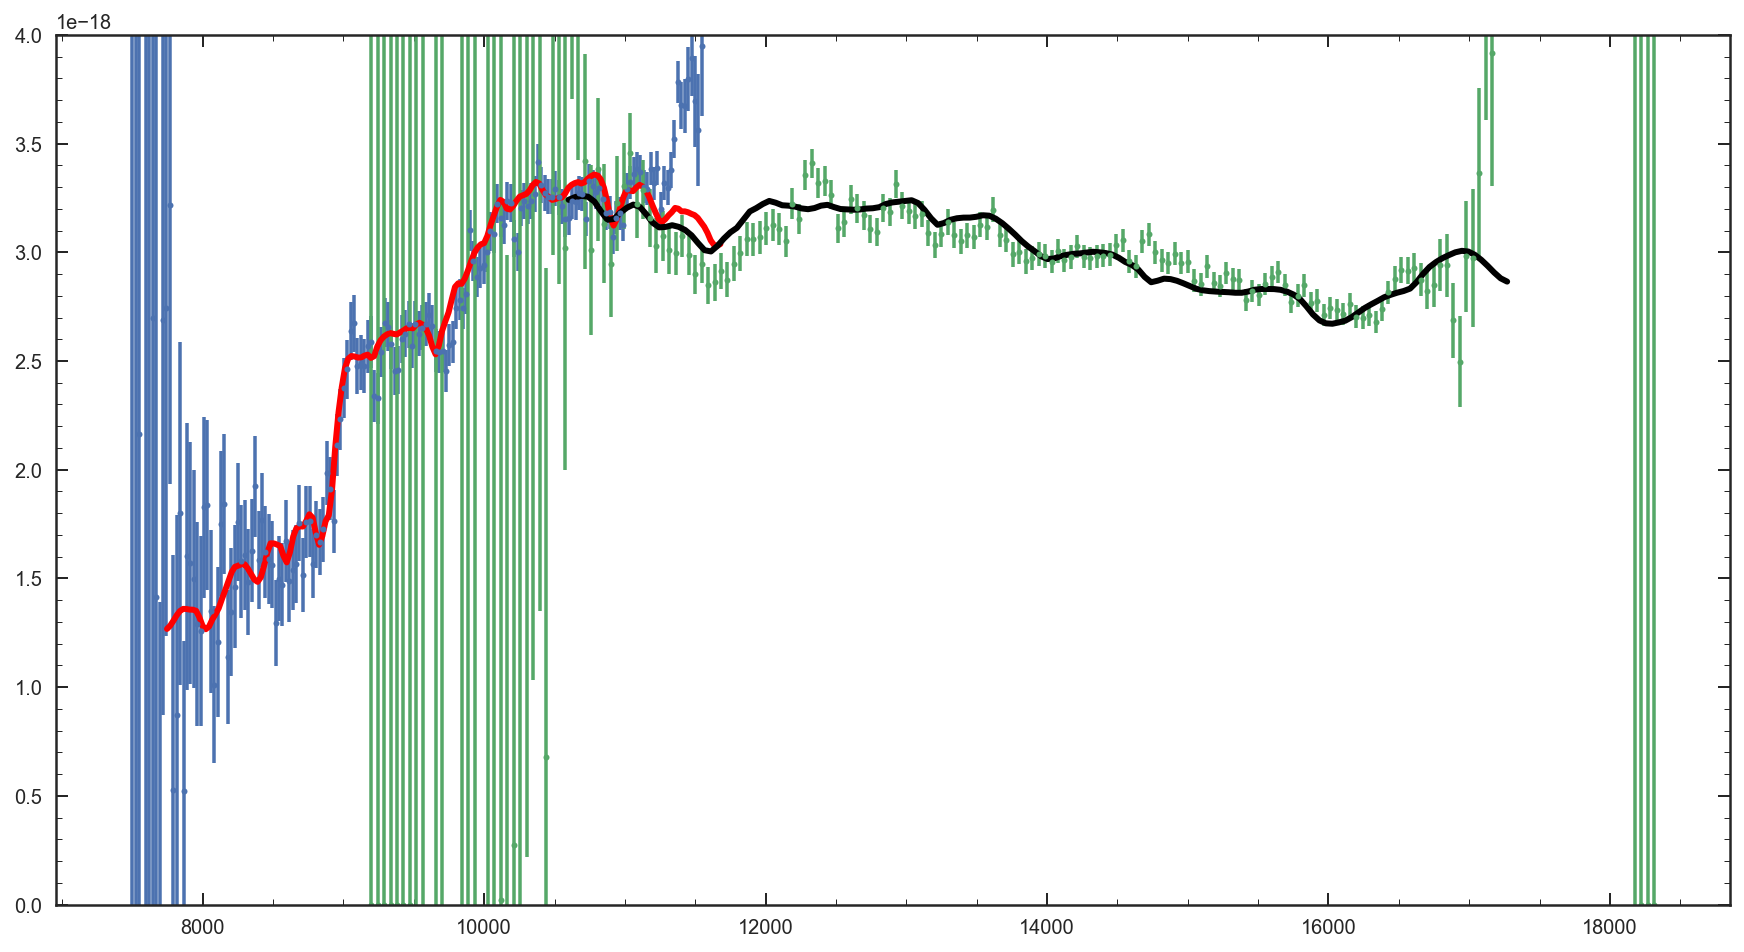

In [49]:
plt.figure(figsize=[15,8])
plt.errorbar(wv_102, fl_102, er_102, linestyle='None', marker='o', markersize=3)
plt.errorbar(wv_141, fl_141, er_141, linestyle='None', marker='o', markersize=3)
plt.plot(mwv_102,C_102*mfl_102, 'r', linewidth=3)
plt.plot(mwv_141,C_141*mfl_141, 'k', linewidth=3)

plt.ylim(0,0.4E-17)

In [33]:
class Gen_MB_spec(object):
    def __init__(self, beams, redshift, spec_file_102, spec_file_141, minwv_102 = 7800, maxwv_102 = 11400,
                minwv_141 = 10700, maxwv_141 = 16000):
        self.mb = multifit.MultiBeam(beams)
        self.redshift = redshift
        
        """ 


        """
        self.gal_wv_102, self.gal_fl_102, self.gal_er_102 = np.load(spec_file_102)

        IDX = [U for U in range(len(self.gal_wv_102)) if minwv_102 <= self.gal_wv_102[U] <= maxwv_102]

        self.gal_wv_rf_102 = self.gal_wv_102[IDX] / (1 + self.redshift)
        self.gal_wv_102 = self.gal_wv_102[IDX]
        self.gal_fl_102 = self.gal_fl_102[IDX]
        self.gal_er_102 = self.gal_er_102[IDX]

        self.gal_wv_141, self.gal_fl_141, self.gal_er_141 = np.load(spec_file_141)

        IDX = [U for U in range(len(self.gal_wv_141)) if minwv_141 <= self.gal_wv_141[U] <= maxwv_141]

        self.gal_wv_rf_141 = self.gal_wv_141[IDX] / (1 + self.redshift)
        self.gal_wv_141 = self.gal_wv_141[IDX]
        self.gal_fl_141 = self.gal_fl_141[IDX]
        self.gal_er_141 = self.gal_er_141[IDX]
        
        ## Get sensitivity function
        flat = self.mb.optimal_extract(self.mb.flat_flam[self.mb.fit_mask])
        
        self.filt_102 = interp1d(flat['G102']['wave'], flat['G102']['flux'])(self.gal_wv_102)
        self.filt_141 = interp1d(flat['G141']['wave'], flat['G141']['flux'])(self.gal_wv_141)
        
        
    def Sim_spec(self, model_file, model_redshift = 0):
        mwv, mfl = np.load(model_file)
        
        if model_redshift ==0:
            model_redshift = self.redshift 
        
        ## Create model
        spec = self.mb.get_flat_model(spectrum_1d = [mwv *(1 + model_redshift), mfl])

        ## Extract model and flat
        sp = self.mb.optimal_extract(spec)
        
        ifl = interp1d(sp['G102']['wave'], sp['G102']['flux'])(self.gal_wv_102)
        
        C = Scale_model(self.gal_fl_102, self.gal_er_102, ifl / self.filt_102)

        self.fl_102 = C * ifl / self.filt_102
        
        ifl = interp1d(sp['G141']['wave'], sp['G141']['flux'])(self.gal_wv_141)
        
        C = Scale_model(self.gal_fl_141, self.gal_er_141, ifl / self.filt_141)

        self.fl_141 = C * ifl / self.filt_141

In [34]:
sp = Gen_MB_spec('beams/gnd_21156.beams.fits', 1.255, 'galaxy_spec_g102.npy', 'galaxy_spec_g141.npy')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 flt_files/ib3721xiq_flt.fits G141
2 flt_files/ib3721xmq_flt.fits G141
3 flt_files/ib3721xyq_flt.fits G141
4 flt_files/ib3721y2q_flt.fits G141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5 flt_files/ib3725dyq_flt.fits G141
6 flt_files/ib3725e2q_flt.fits G141
7 flt_files/ib3725eeq_flt.fits G141
8 flt_files/ib3725eiq_flt.fits G141
9 flt_files/icat21cfq_flt.fits G102
10 flt_files/icat21coq_flt.fits G102
11 flt_files/icat21dgq_flt.fits G102
12 flt_files/icat21dlq_flt.fits G102
13 flt_files/icat25hcq_flt.fits G102
14 flt_files/icat25hiq_flt.fits G102
15 flt_files/icat25icq_flt.fits G102
16 flt_files/icat25iiq_flt.fits G102
17 flt_files/icxt51jvq_flt.fits G102
18 flt_files/icxt51jwq_flt.fits G102
19 flt_files/icxt51jzq_flt.fits G102
20 flt_files/icxt51k1q_flt.fits G102
21 flt_files/icxt52i0q_flt.fits G102
22 flt_files/icxt52i1q_flt.fits G102
23 flt_files/icxt52i4q_flt.fits G102
24 flt_files/icxt52i6q_flt.fits G102
25 flt_files/icxt53i9q_flt.fits G102
26 flt_files/icxt53iaq_flt.fits G102
27 flt_files/icxt53idq_flt.fits G102
28 flt_files/icxt53ifq_flt.fits G102
29 flt_files/icxt55krq_flt.fits G102
30 flt_files/icxt55ksq_flt.fits G102
31 flt_files/icxt55kvq_flt.fits G102
32 flt

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1200: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1328: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1333: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:2948: FutureWarning: `rcond` parameter will change to the default of

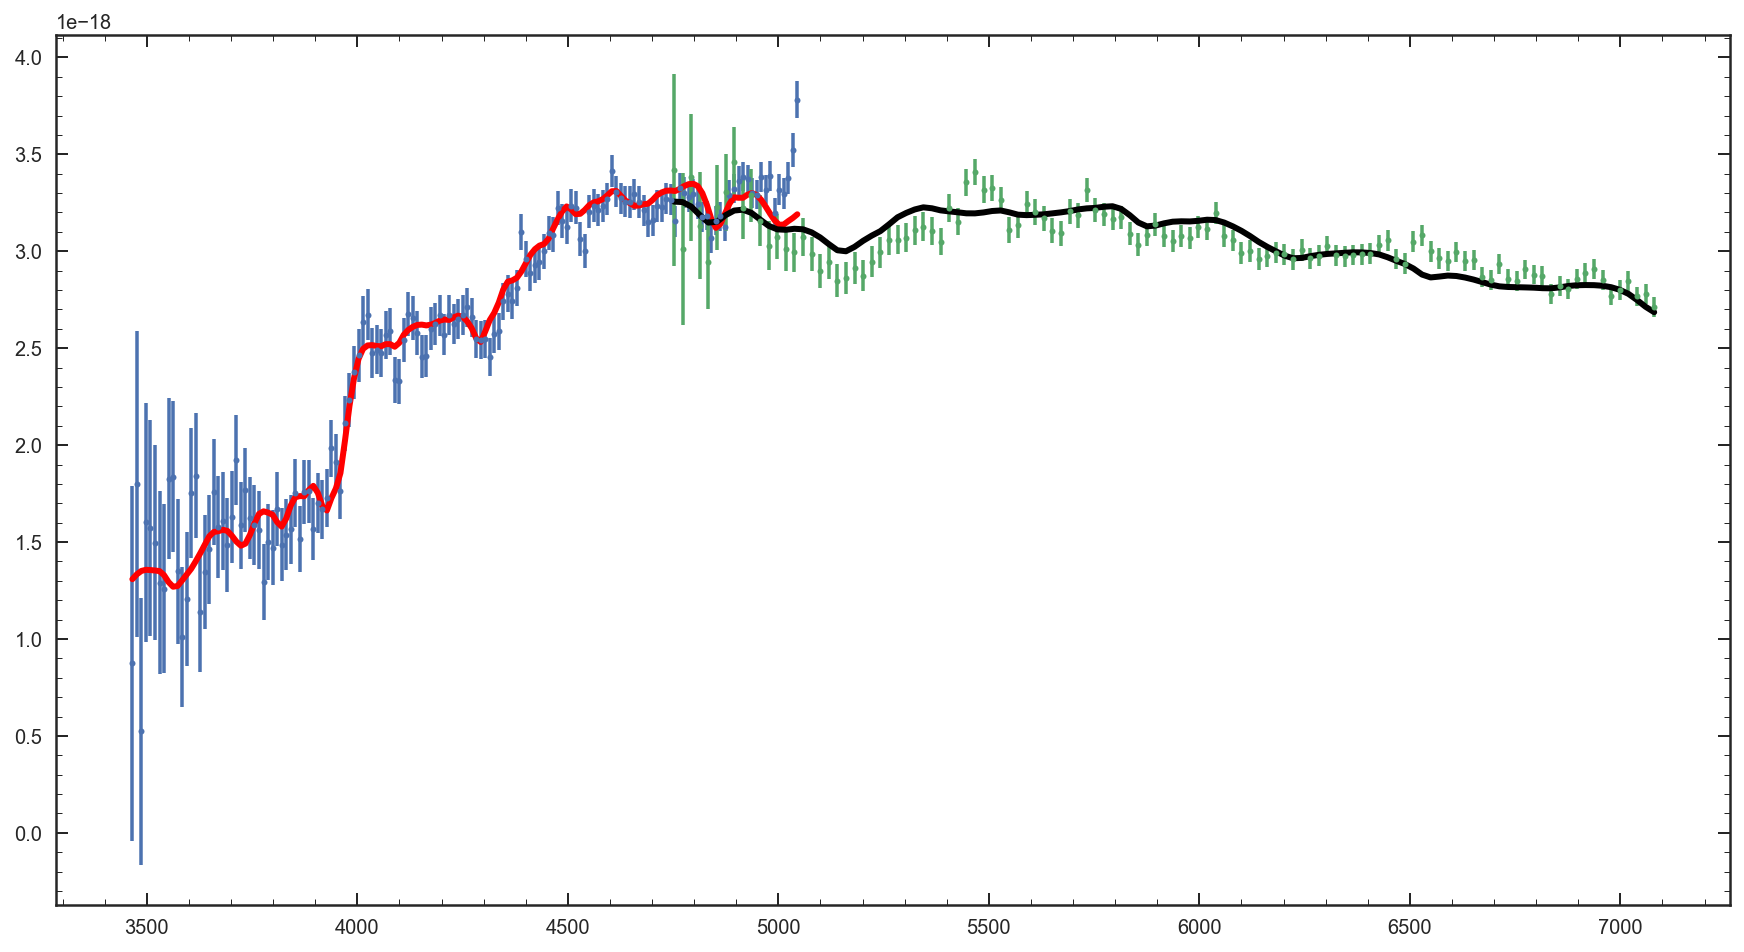

In [35]:
sp.Sim_spec('model_spec/m0.019_a2.5_dt8.0_spec.npy')

plt.figure(figsize=[15,8])
plt.errorbar(sp.gal_wv_rf_102, sp.gal_fl_102, sp.gal_er_102, linestyle='None', marker='o', markersize=3)
plt.errorbar(sp.gal_wv_rf_141, sp.gal_fl_141, sp.gal_er_141, linestyle='None', marker='o', markersize=3)

plt.plot(sp.gal_wv_rf_102,sp.fl_102, 'r', linewidth=3)
plt.plot(sp.gal_wv_rf_141,sp.fl_141, 'k', linewidth=3)
